<a href="https://colab.research.google.com/github/diagiraldo/PRETTIER/blob/main/run_example_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Run example

Created by Diana Giraldo, April 2024
Last modification: April 2024

## Import Modules

In [2]:
import os,sys
import torch
import numpy as np
import nibabel as nib

In [3]:
cwd_path = %pwd
print(cwd_path)

/content


In [4]:
!git clone https://github.com/diagiraldo/PRETTIER.git

Cloning into 'PRETTIER'...
remote: Enumerating objects: 76, done.
remote: Counting objects: 100% (11/11), done.
remote: Compressing objects: 100% (10/10), done.
remote: Total 76 (delta 1), reused 6 (delta 1), pack-reused 65
Receiving objects: 100% (76/76), 207.01 MiB | 32.71 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [5]:
repo_dir = os.path.join(cwd_path, "PRETTIER")
sys.path.insert(0, repo_dir)
from prettier.srr_mri import reconstruct_volume
from prettier.utils.plots import show_orthoslices

In [6]:
COMBINE_VOL_METHOD = "average"
FT_WEIGHTS_URLS = {
    'RealESRGAN': "https://drive.google.com/uc?export=download&id=15xWVa7C4IISiMlXIdee2yjjZne2dufJh",
    'EDSR': "https://drive.google.com/uc?export=download&id=13E-EKIdHW6QyrZiLE8WvvDcJ1vnP9RgS",
}

## Set-up example

In [16]:
example_input_fpath = os.path.join(repo_dir, "demo_data", "real_noface_LR_FLAIR.nii.gz")
model_name = "EDSR"
batch_size = 6

example_output_fpath = os.path.join(repo_dir, "demo_data", "prettier_edsr_real_FLAIR.nii.gz")

### Check existence of fine-tuned weights

In [8]:
weights_fpath = os.path.join(repo_dir, "weights", model_name + "_finetuned.pth")
if not os.path.isfile(weights_fpath):
    #raise ValueError('File with weights not found in', weights_fpath)
    print(f'Fine-tuned weights not found in {weights_fpath}, trying to download it...')
    import gdown
    gdown.download(FT_WEIGHTS_URLS[model_name], weights_fpath)

else:
    print(f'Fine-tuned weights found in {weights_fpath}')

Fine-tuned weights not found in /content/PRETTIER/weights/EDSR_finetuned.pth, trying to download it...


Downloading...
From (original): https://drive.google.com/uc?export=download&id=13E-EKIdHW6QyrZiLE8WvvDcJ1vnP9RgS
From (redirected): https://drive.google.com/uc?export=download&id=13E-EKIdHW6QyrZiLE8WvvDcJ1vnP9RgS&confirm=t&uuid=5b5fcbd3-6da4-4622-825d-9c11f5ec2fc6
To: /content/PRETTIER/weights/EDSR_finetuned.pth
100%|██████████| 172M/172M [00:02<00:00, 79.5MB/s]


### Check device

In [9]:
device = torch.device(f'cuda' if torch.cuda.is_available() else 'cpu')
print("Device:", device)

Device: cuda


## Load input

LR image: /content/PRETTIER/demo_data/real_noface_LR_FLAIR.nii.gz
Image array shape: [288 288  28]
Voxel size: [0.8333333 0.8333333 6.       ]
Orientation of voxel axes: ('L', 'P', 'S')


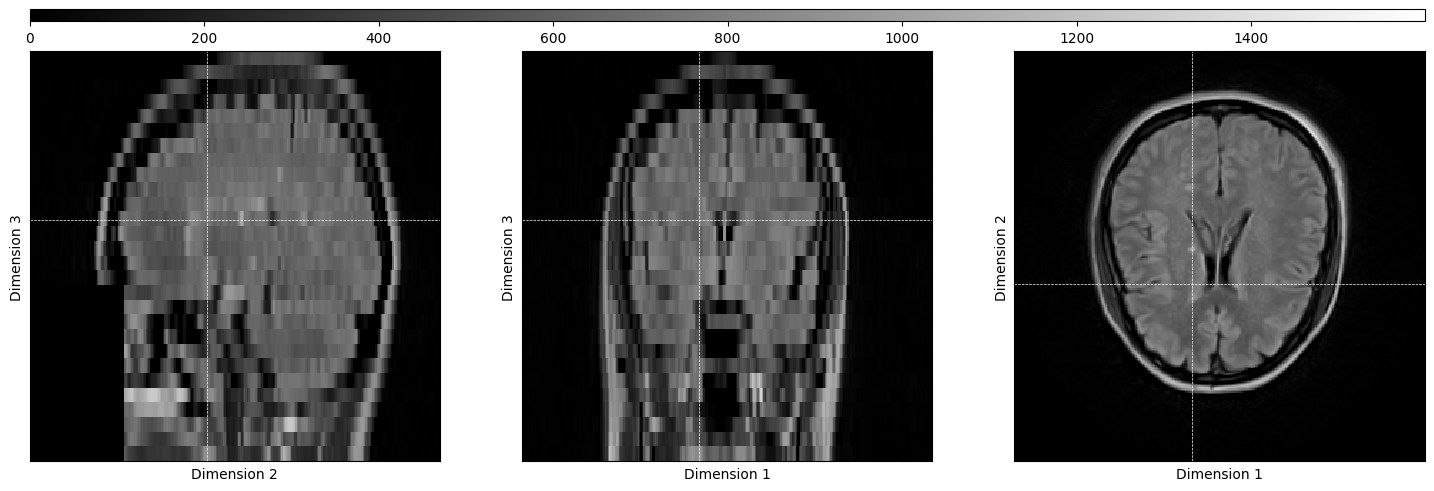

In [10]:
LR = nib.load(example_input_fpath)
print("LR image:", example_input_fpath)
print('Image array shape:', LR.header['dim'][1:4])
print('Voxel size:', LR.header['pixdim'][1:4])
print('Orientation of voxel axes:', nib.aff2axcodes(LR.affine))
show_orthoslices(
    LR.get_fdata(),
    cross = [124, 124, 16],
    vmin = 0, vmax = np.max(LR.get_fdata()),
    show_cross = True,
)

Check orientation of axis and flip them if necessary:

Flipping axes of LR input
New orientation of voxel axes: ('R', 'A', 'S')


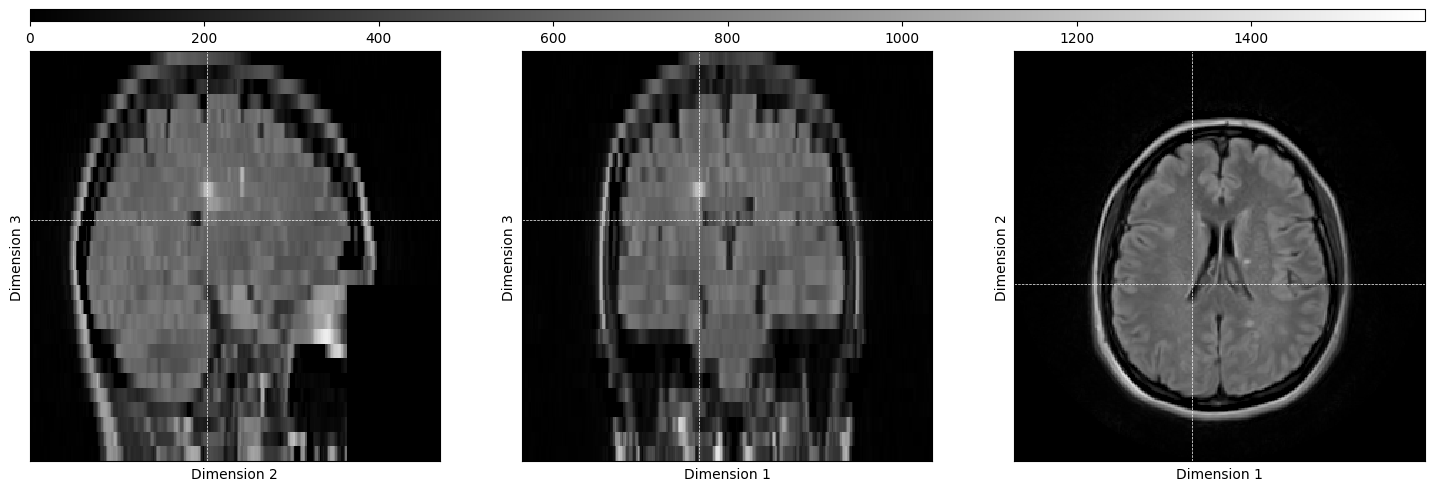

In [11]:
original_ori = nib.io_orientation(LR.affine)
flip_axes = (np.min(original_ori[:,1]) < 0)

if flip_axes:
    print("Flipping axes of LR input")
    flipping = original_ori
    flipping[:,0] = [0,1,2]
    LR = LR.as_reoriented(flipping)
    print('New orientation of voxel axes:', nib.aff2axcodes(LR.affine))
    show_orthoslices(
        LR.get_fdata(),
        cross = [124, 124, 16],
        vmin = 0, vmax = np.max(LR.get_fdata()),
        show_cross = True,
    )

## Load SR model

In [13]:
if model_name == "EDSR":
    from prettier.models.edsr import EDSR
    model = EDSR(n_colorchannels = 3, scale = 4)
    model.load_state_dict(torch.load(weights_fpath)['model_weights'])
    scale_factor = 255

elif model_name == "RealESRGAN":
    from basicsr.archs.rrdbnet_arch import RRDBNet
    model = RRDBNet(num_in_ch=3, num_out_ch=3, num_feat=64, num_block=23, num_grow_ch=32, scale=4)
    model.load_state_dict(torch.load(weights_fpath)['generator_weights'])
    scale_factor = None

else:
    print("model name not valid")

In [14]:
model.eval()
model = model.to(device)

## Run SR reconstruction

In [20]:
rec, v2w = reconstruct_volume(
    LR,
    model,
    device,
    batch_size = batch_size,
    scale_factor = scale_factor,
    slices_as_channels = True,
    select_middle = False,
    return_vol_list = False,
    combine_vol_method = COMBINE_VOL_METHOD,
)

hr_nib = nib.Nifti1Image(rec, v2w)

-------------------------------------------
Slicing dimension: 0


100%|██████████| 48/48 [00:48<00:00,  1.01s/batch]


Inference time: 48.362120151519775
-------------------------------------------
Slicing dimension: 1


100%|██████████| 48/48 [00:46<00:00,  1.04batch/s]


Inference time: 46.36179065704346
-------------------------------------------
Combining volumes
Total reconstruction time: 95.72135806083679


### Check reconstruction

Image array shape: [288 288 168]
Voxel size: [0.8333333 0.8333333 1.       ]
Orientation of voxel axes: ('R', 'A', 'S')


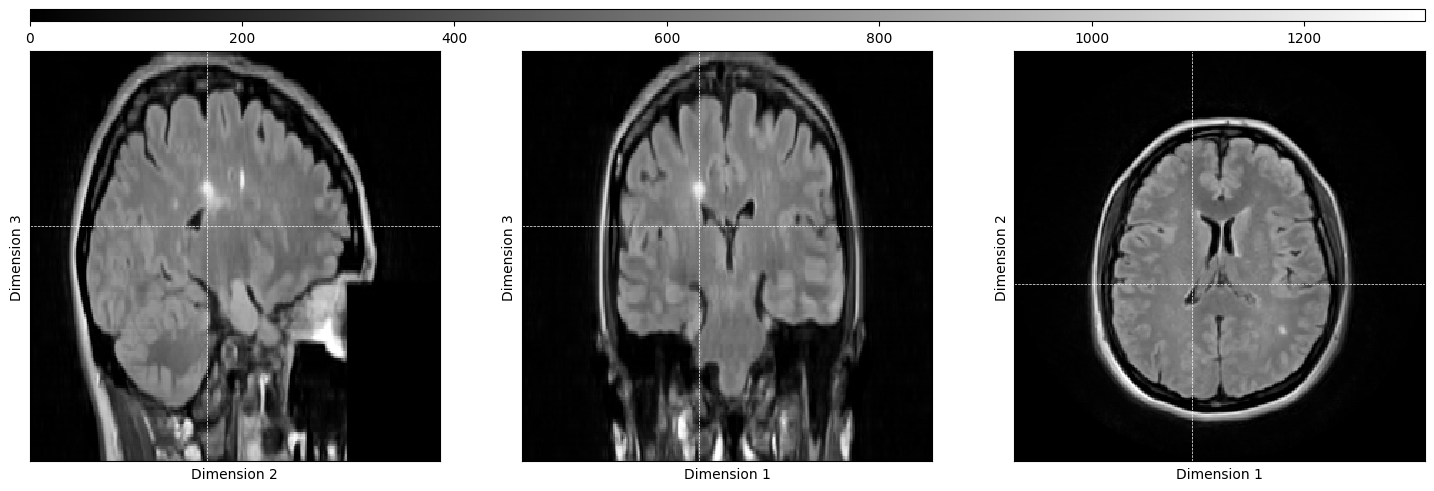

In [17]:
print('Image array shape:', hr_nib.header['dim'][1:4])
print('Voxel size:', hr_nib.header['pixdim'][1:4])
print('Orientation of voxel axes:', nib.aff2axcodes(hr_nib.affine))
show_orthoslices(
    hr_nib.get_fdata(),
    cross = [124, 124, 16*6],
    vmin = 0, vmax = np.max(hr_nib.get_fdata()),
    show_cross = True,
)

Flip back axes, if necessary

Flipping axes of HR output


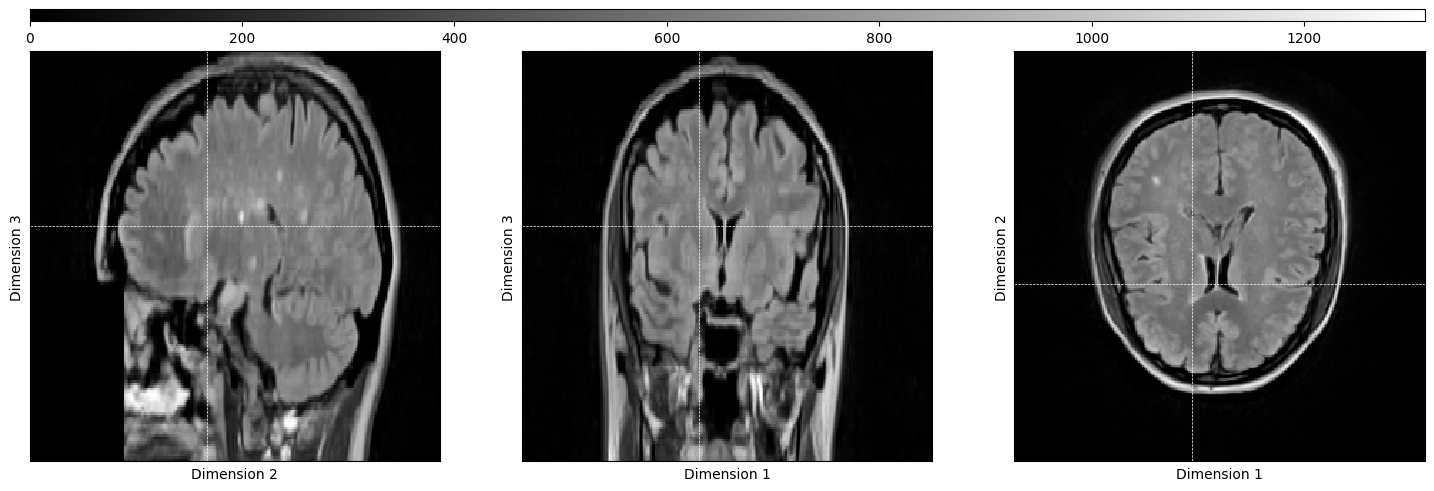

In [18]:
if flip_axes:
    print("Flipping axes of HR output")
    hr_nib = hr_nib.as_reoriented(flipping)
    show_orthoslices(
        hr_nib.get_fdata(),
        cross = [124, 124, 16*6],
        vmin = 0, vmax = np.max(hr_nib.get_fdata()),
        show_cross = True,
    )

## Save output

In [19]:
nib.save(hr_nib, example_output_fpath)